In [1]:
dataset_path = 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/8j2g3csprk-2.zip'
# download the zip file


In [2]:
# prompt: download and extract the zip file

import requests
import zipfile
import io

def download_and_extract_zip(url, extract_to='.'):
  """Downloads a zip file from a URL and extracts it to a specified directory.

  Args:
    url: The URL of the zip file.
    extract_to: The directory to extract the zip file to. Defaults to the current directory.
  """
  try:
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an exception for bad status codes

    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
      zip_ref.extractall(extract_to)
    print(f"Successfully downloaded and extracted from {url} to {extract_to}")
  except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}")
  except zipfile.BadZipFile as e:
    print(f"Error extracting zip file: {e}")


download_and_extract_zip(dataset_path)

Successfully downloaded and extracted from https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/8j2g3csprk-2.zip to .


In [3]:
import os
path = '/content/Dataset of Tuberculosis Chest X-rays Images'
os.listdir(path)

['TB Chest X-rays', 'Normal Chest X-rays']

In [4]:
import pandas as pd
classnames = ['Normal', 'Tuberculosis']
classname_folders = ['Normal Chest X-rays', 'TB Chest X-rays']
df = []
for folder, cls in zip(classname_folders, classnames):
   for img in os.listdir(os.path.join(path, folder)):
      df.append({'img': os.path.join(path, folder, img),'label': cls})

df = pd.DataFrame(df)
df.head()


,img,label
0,/content/Dataset of Tuberculosis Chest X-rays ...,Normal
1,/content/Dataset of Tuberculosis Chest X-rays ...,Normal
2,/content/Dataset of Tuberculosis Chest X-rays ...,Normal
3,/content/Dataset of Tuberculosis Chest X-rays ...,Normal
4,/content/Dataset of Tuberculosis Chest X-rays ...,Normal


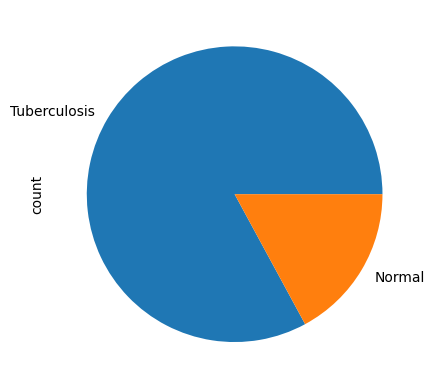

In [5]:
import matplotlib.pyplot as plt
df['label'].value_counts().plot(kind='pie')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame with 'img' and 'label' columns

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)

print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

# You can further analyze the label distribution in train and test sets:
print("\nTraining set label distribution:")
print(train_df['label'].value_counts())
print("\nTesting set label distribution:")
print(test_df['label'].value_counts())

Training set shape: (2406, 2)
Testing set shape: (602, 2)

Training set label distribution:
label
Tuberculosis    1995
Normal           411
Name: count, dtype: int64

Testing set label distribution:
label
Tuberculosis    499
Normal          103
Name: count, dtype: int64


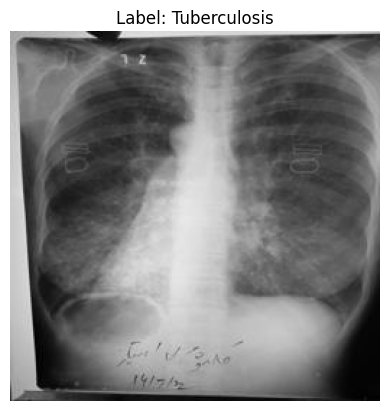

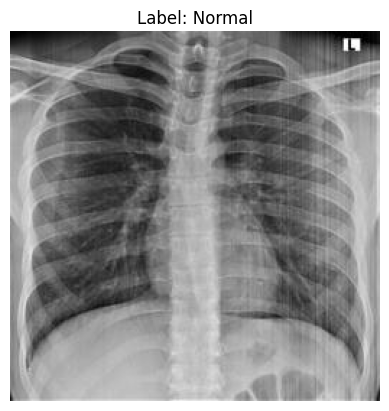

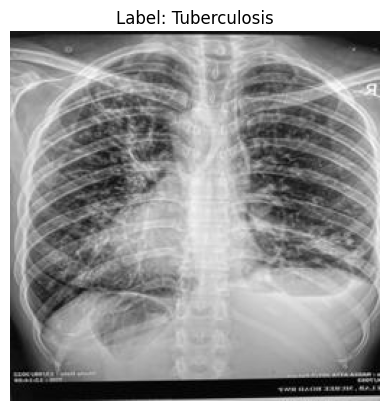

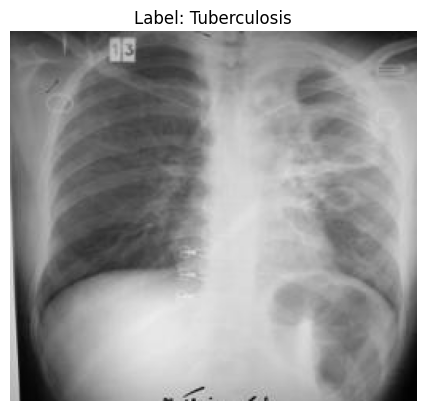

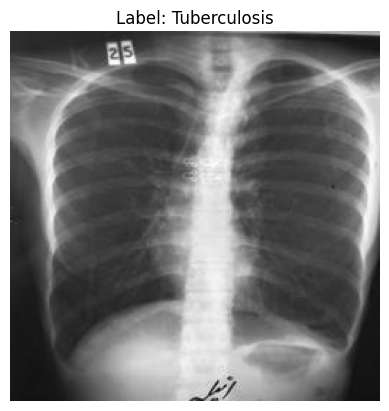

In [7]:
# prompt: sample few images from train_df and display them using matplotlib imshow

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Sample a few images from train_df
sample_images = train_df.sample(n=5)  # You can change the number of samples

# Display the images using matplotlib imshow
for index, row in sample_images.iterrows():
  img_path = row['img']
  label = row['label']
  try:
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')  # Turn off axis labels
    plt.show()
  except FileNotFoundError:
    print(f"File not found: {img_path}")

In [8]:
labels_to_nbrs = {'Normal': 0, 'Tuberculosis': 1}
nbrs_to_labels = {0: 'Normal',1: 'Tuberculosis'}

In [9]:
# prompt: create a custom dataset using pytorch

import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class TBDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['img']
        label = self.dataframe.iloc[idx]['label']

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, labels_to_nbrs[label]


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = TBDataset(train_df, transform=transform)
test_dataset = TBDataset(test_df, transform=transform)


In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

torch.manual_seed(42)
torch.cuda.manual_seed(42)
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [11]:
# prompt: create CNN  for image classification where input image size is 3 * 224 * 224 and number of classes is 2

import torch.nn as nn
import torch.nn.functional as F

class TBCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(TBCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Sequential(
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = self.fc(x)
        return x

model = TBCNN(num_classes=1).to(device)

In [17]:
# Create the model
model = TBCNN().to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss().to(device)  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Example training loop
for epoch in range(10):  # Number of epochs
    running_loss = 0.0
    for images, labels in train_loader:
        # Move data to device if using GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.float().unsqueeze(1))  # Ensure labels match shape
        running_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    running_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{10}, Loss: {running_loss}")


Epoch 1/10, Loss: 0.15543084091347592
Epoch 2/10, Loss: 0.027015138123524116
Epoch 3/10, Loss: 0.008559243683569213
Epoch 4/10, Loss: 0.006878275851545966
Epoch 5/10, Loss: 0.02201262954685521
Epoch 6/10, Loss: 0.006749427675003972
Epoch 7/10, Loss: 0.0005272605994256788
Epoch 8/10, Loss: 0.00012664762867642984
Epoch 9/10, Loss: 0.002078158693523703
Epoch 10/10, Loss: 0.00033323043219985794


In [18]:

# save the model
torch.save(model.state_dict(), 'tb_cnn.pth')


In [19]:
!pip install torchmetrics

In [20]:
# prompt: calculate accuracy, precision, recall, f1 score in test_loader

from torchmetrics import Accuracy, Precision, Recall, F1Score

# Assuming you have your test_loader and model loaded

# Initialize metrics
accuracy = Accuracy(task='binary').to(device)
precision = Precision(task='binary').to(device)
recall = Recall(task='binary').to(device)
f1_score = F1Score(task='binary').to(device)

# Put the model in evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Make predictions
        outputs = model(images)
        preds = (outputs > 0.5).int()  # Convert probabilities to binary predictions

        # Update metrics
        accuracy.update(preds, labels.unsqueeze(1))
        precision.update(preds, labels.unsqueeze(1))
        recall.update(preds, labels.unsqueeze(1))
        f1_score.update(preds, labels.unsqueeze(1))


        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Compute and print the metrics
print(f"Accuracy: {accuracy.compute()}")
print(f"Precision: {precision.compute()}")
print(f"Recall: {recall.compute()}")
print(f"F1-Score: {f1_score.compute()}")

Accuracy: 0.9950166344642639
Precision: 1.0
Recall: 0.9939879775047302
F1-Score: 0.9969848990440369


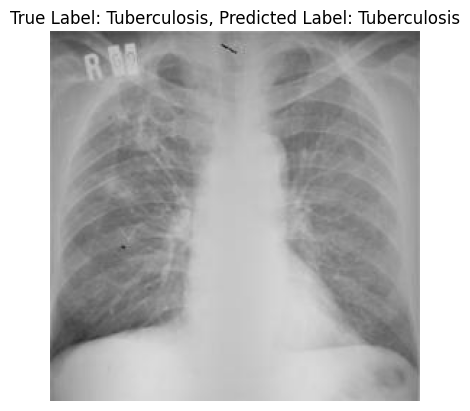

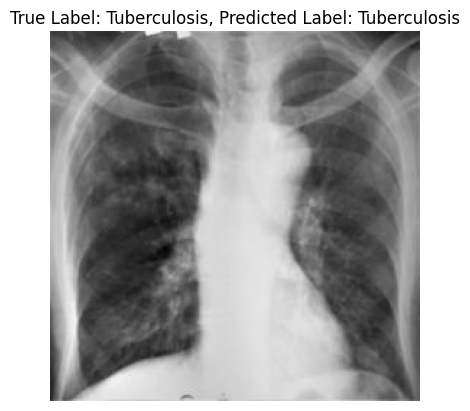

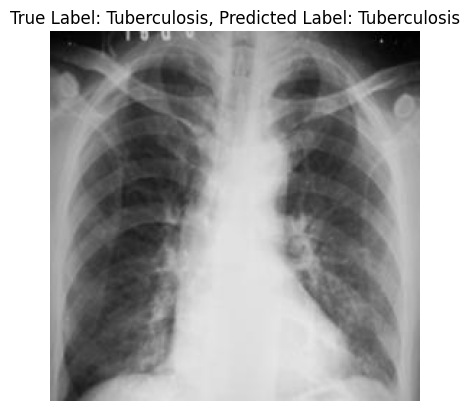

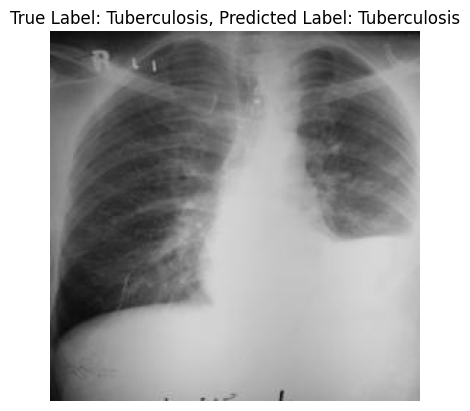

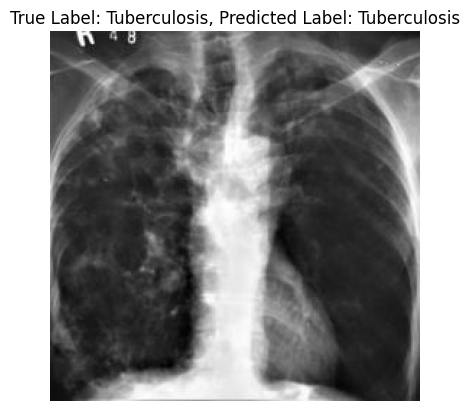

In [21]:
# prompt: sample few images from test_df, run the imaes through model and get predictions and visualise

import numpy as np

# Sample a few images from test_df
sample_images = test_df.sample(n=5)

# Assuming you have your model and device defined
model.eval()

# Iterate through the sample images
for index, row in sample_images.iterrows():
  img_path = row['img']
  label = row['label']

  try:
    # Load and preprocess the image
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Get the model's prediction
    with torch.no_grad():
      output = model(image)
      pred = (output > 0.5).int().item()  # Convert to binary prediction

    # Display the image and prediction
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"True Label: {label}, Predicted Label: {nbrs_to_labels[pred]}")
    plt.axis('off')
    plt.show()

  except FileNotFoundError:
    print(f"File not found: {img_path}")